In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import os
import cv2
# Load the images directories
path = "C:/Users/rohan/OneDrive/Desktop/Final Project/Code/input/Detection"
image_paths = list(paths.list_images(path))

In [2]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

In [3]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

In [4]:
from sklearn.model_selection import train_test_split

(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input

base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

In [7]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
batch_size = 10
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 8

In [11]:
history = model.fit(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs)

Epoch 1/8
62/62 [==============================] - 164s 3s/step - loss: 0.6472 - accuracy: 0.6628 - val_loss: 0.5297 - val_accuracy: 0.8841
Epoch 2/8
62/62 [==============================] - 177s 3s/step - loss: 0.5090 - accuracy: 0.8032 - val_loss: 0.4248 - val_accuracy: 0.8986
Epoch 3/8
62/62 [==============================] - 175s 3s/step - loss: 0.4204 - accuracy: 0.8609 - val_loss: 0.3463 - val_accuracy: 0.9420
Epoch 4/8
62/62 [==============================] - 173s 3s/step - loss: 0.3542 - accuracy: 0.8953 - val_loss: 0.3216 - val_accuracy: 0.8696
Epoch 5/8
62/62 [==============================] - 175s 3s/step - loss: 0.3102 - accuracy: 0.9051 - val_loss: 0.2343 - val_accuracy: 0.9710
Epoch 6/8
62/62 [==============================] - 174s 3s/step - loss: 0.2644 - accuracy: 0.9116 - val_loss: 0.2064 - val_accuracy: 0.9710
Epoch 7/8
62/62 [==============================] - 168s 3s/step - loss: 0.2404 - accuracy: 0.9313 - val_loss: 0.1905 - val_accuracy: 0.9565
Epoch 8/8
62/62 [===

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

print('Prediction:',predictions)
print('Actual:',actuals)

Prediction: [0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0
 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0]
Actual: [0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 0 0 0
 1 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0]


In [13]:
print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

              precision    recall  f1-score   support

          no       1.00      0.95      0.97        39
         yes       0.94      1.00      0.97        30

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69

[[37  2]
 [ 0 30]]


In [14]:
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9710


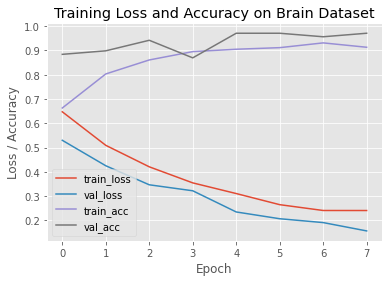

In [15]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")

Prediction is No
Actual is No


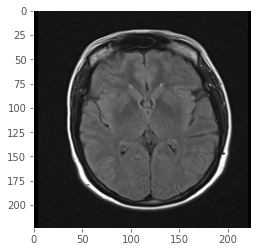

In [16]:
print(f'Prediction is {"Yes" if predictions[20]==1 else "No"}')
print(f'Actual is {"Yes" if actuals[20]==1 else "No"}')
plt.imshow(test_X[20])
plt.grid(False)